Loading all the libraries

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

Preprocessing and create dataset functions

In [2]:
IMG_SIZE=256

def parse_image(path, label):
    # Load and decode
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=1) 
    # Resize
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    # Scale to [0,1] or do further normalization
    image = image / 255.0
    return image, label

def create_dataset(paths, labs, batch_size=16):
    ds = tf.data.Dataset.from_tensor_slices((paths, labs))

    ds = ds.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)

    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

Preprocessing and creation of test dataset

In [3]:
test_dir = "Lung cancer detection/valid"
test_image_paths = []
test_labels = []
test_class_names = sorted(os.listdir(test_dir))  # Should match class_names

for label_idx, class_name in enumerate(test_class_names):
    class_folder = os.path.join(test_dir, class_name)
    for fname in os.listdir(class_folder):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            test_image_paths.append(os.path.join(class_folder, fname))
            test_labels.append(label_idx)

test_image_paths = np.array(test_image_paths)
test_labels = np.array(test_labels)

ds_test = create_dataset(test_image_paths, test_labels)

Loading the model and showing its summary

In [4]:
# Load the trained model
model = load_model("m89acc.keras")

# Print the model summary
print("\nModel Summary:")
model.summary()


Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,516,750 (169.82 MB)

 Trainable params: 14,838,916 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 29,677,834 (113.21 MB)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

Model Evaluation Metrics:
Accuracy: 0.8889
Precision: 0.8898
Recall: 0.8889
F1 Score: 0.8881

Classification Report:
                                                   precision    recall  f1-score   support

      adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib       0.86      0.78      0.82        23
   large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa       0.90      0.90      0.90        21
                                          normal       1.00      1.00      1.00        13
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa       0.82      0.93      0.88        15

                                        accuracy                           0.89        72
                                       macro avg       0.90      0.91      0.90        72
                                    weighted avg       0.89      0.89      0.89        72



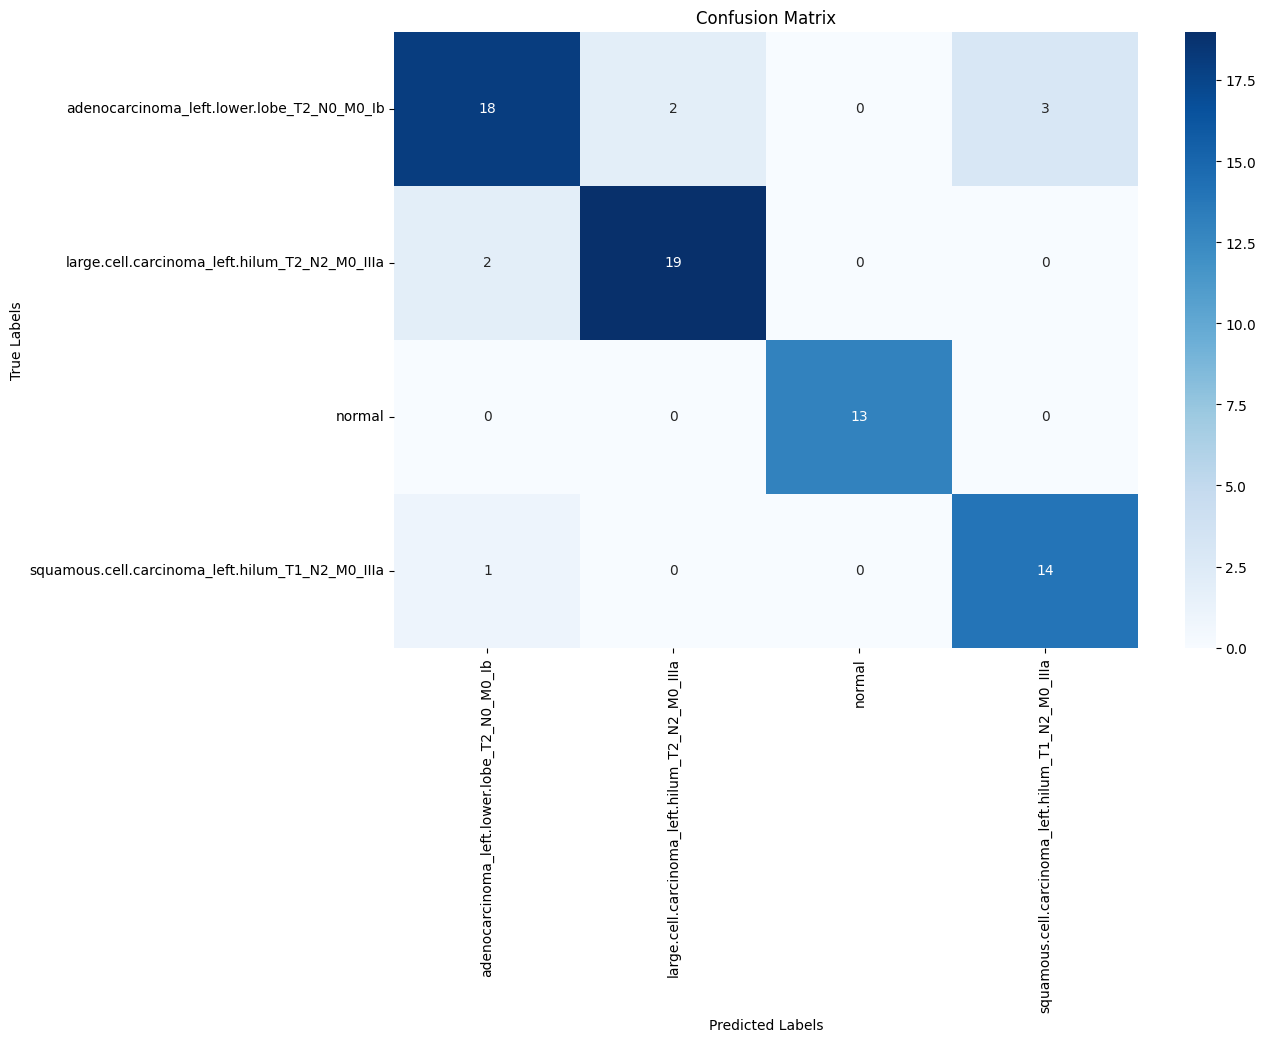

In [5]:

# Get predictions
pred_probs = model.predict(ds_test)
pred_labels = np.argmax(pred_probs, axis=1)

# Calculate metrics
accuracy = accuracy_score(test_labels, pred_labels)
precision = precision_score(test_labels, pred_labels, average="weighted")
recall = recall_score(test_labels, pred_labels, average="weighted")
f1 = f1_score(test_labels, pred_labels, average="weighted")

# Print evaluation metrics
print(f"\nModel Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Generate classification report
report = classification_report(test_labels, pred_labels, target_names=test_class_names, zero_division=0)
print("\nClassification Report:\n", report)

# Confusion matrix
cm = confusion_matrix(test_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_class_names, yticklabels=test_class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
